In [1]:
from venture import shortcuts

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import codecs
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
ripl = shortcuts.make_lite_ripl()

Couldn't import dot_parser, loading of dot files will not be possible.


# Create Training Data

Number of training data

In [4]:
n = 30

Number of test data

In [5]:
n_test = 200

input data

In [6]:
data_x = np.random.uniform(-2,2,n+n_test)
data_y = np.random.uniform(-5,9,n+n_test)

helper functions & data

In [7]:
f = lambda x: x**4 - 2*x**2 + x
fx = np.linspace(-2,2,500)

In [8]:
all_labels = []
for i,point in enumerate(data_y):
    if f(data_x[i])>point:
        all_labels.append(1)
    else:
        all_labels.append(0)

In [9]:
training_data_x = data_x[0:n]
training_data_y = data_y[0:n]
training_labels = all_labels[0:n]

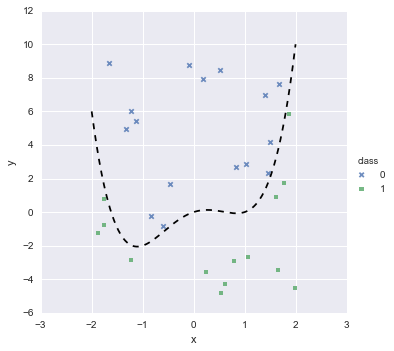

In [10]:
df = pd.DataFrame({"x":training_data_x, "y":training_data_y, "class":training_labels})
sns.lmplot("x", "y", data=df, hue='class', markers =["x","s"], fit_reg=False)
plt.plot(fx,f(fx),c = 'k',linestyle="--")
xmin,xmax,ymin,ymax = plt.axis()

# The Venture Program

In [11]:
program = """
// Fake GP

assume fake_gp = proc(mean_function, covariance_function){
    proc(x,y){
        zeros = fill(size(x), 0);
        ones = fill(size(x), 1);
        multivariate_normal(fill(size(x),1),diag_matrix(ones))
    
    }

};


// FIXME - why does this throw error when I write exp( - x ) instead
assume sigmoid = proc(x){1./(1. + exp(0 - x ))};


// Hyper-parameters

assume tolerance_constant = 00000.1;

assume noise_sigma = tag("hyper", 0, gamma(5,1));

assume scale_factor = tag("hyper", 1, gamma(5,1));
assume length_scale = tag("hyper", 2, gamma(5,1));


assume noise_kernel = gp_cov_scale(noise_sigma,gp_cov_delta(tolerance_constant));
assume se_kernel = gp_cov_scale(scale_factor, gp_cov_se(length_scale));

assume covariance_kernel = gp_cov_sum(se_kernel, noise_kernel);

assume zero_mean_function =gp_mean_const(0.);

assume gp = fake_gp(zero_mean_function, covariance_kernel);

assume obs_func = proc(x,y){bernoulli(sigmoid(lookup(gp(array(x),array(y)),0)))};


"""
ripl.execute_program(program);

# Create Test Data

In [12]:
n_test = 200
test_data_x = data_x[0:(n+n_test)]
test_data_y = data_y[0:(n+n_test)]
test_labels = all_labels[0:n]



# Sample from the Prior

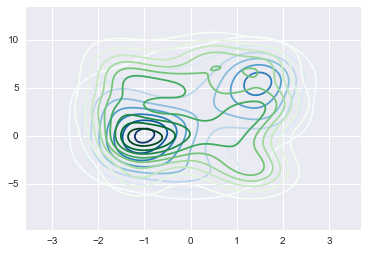

In [13]:
prior_labels = []
prior_length_scale = []
prior_scale_factor = []
prior_noise_sigma = []
for i in range(test_data_x.shape[0]):
    ripl.infer("reset_to_prior")
    prior_labels.append(ripl.sample("obs_func(%d, %d)"  % (test_data_x[i],test_data_y[i],)))
    prior_noise_sigma.append(ripl.sample("noise_sigma")) 
    prior_length_scale.append(ripl.sample("length_scale"))
    prior_scale_factor.append(ripl.sample("scale_factor"))

prior_labels = np.array(prior_labels)
ax = sns.kdeplot(np.array(test_data_x[prior_labels==0]), test_data_y[prior_labels==0],
                  cmap="Blues",  n_levels=10,  shade_lowest=False)
ax = sns.kdeplot(np.array(test_data_x[prior_labels==1]), test_data_y[prior_labels==1],
                  cmap="Greens", n_levels=10, shade_lowest=False)

# Make Observations

In [14]:
for i,x in enumerate(training_data_x):
    ripl.observe("obs_func(%d, %d)"  % (training_data_x[i],training_data_y[i],), training_labels[i])

Inference does not work

In [15]:
ripl.infer("""mh("hyper", one, 100)""")

[7.36]

## What we need to get to run 

In [ ]:
#ripl.infer("grad_ascent(default, all, 0.05, 100, 1)")

## What we probably need to get to work for reasonable inference 

In [ ]:
#ripl.infer("hmc(default, all, 0.05, 100, 1))
# slice sampling?

# Samples from Posterior

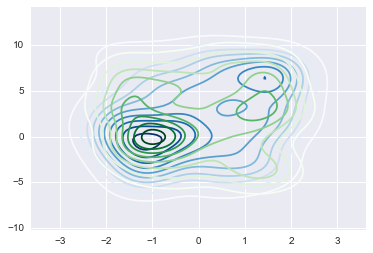

In [16]:
posterior_labels = []
posterior_length_scale = []
posterior_scale_factor = []
posterior_noise_sigma = []
for i in range(test_data_x.shape[0]):
    posterior_labels.append(ripl.sample("obs_func(%d, %d)"  % (test_data_x[i],test_data_y[i],)))
    ripl.infer("""mh("hyper", 0, 1)""")
    posterior_noise_sigma.append(ripl.sample("noise_sigma"))
    ripl.infer("""mh("hyper", 1, 1)""")
    posterior_length_scale.append(ripl.sample("length_scale"))
    ripl.infer("""mh("hyper", 2, 1)""")
    posterior_scale_factor.append(ripl.sample("scale_factor"))
    
    
posterior_labels = np.array(posterior_labels)
ax = sns.kdeplot(np.array(test_data_x[posterior_labels==0]), test_data_y[posterior_labels==0],
                  cmap="Blues",  n_levels=10,  shade_lowest=False)
ax = sns.kdeplot(np.array(test_data_x[posterior_labels==1]), test_data_y[posterior_labels==1],
                  cmap="Greens", n_levels=10, shade_lowest=False)

## above is stubbed and wrong - it should look like this:

(-6.0, 12.0)

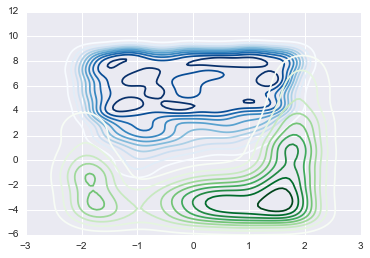

In [17]:
# hacky code simulating how the plot above should actually look like:
x_samples = np.random.uniform(-2,2,5000)
y_samples = np.random.uniform(-5,9,5000)
x_false = []
y_false = []
x_true = []
y_true = []
for i,y_sample in enumerate(y_samples):
    if f(x_samples[i]) > y_sample:
        if np.random.uniform(0,1) < (abs(y_sample - f(x_samples[i])))/abs(abs(f(x_samples[i]) - 7)):
            x_true.append(x_samples[i])
            y_true.append(y_sample)
    else:
        if np.random.uniform(0,1) < (abs(y_sample - f(x_samples[i])))/abs(abs(f(x_samples[i]) - 4)):            
            x_false.append(x_samples[i])
            y_false.append(y_sample)     
ax = sns.kdeplot(np.array(x_false), np.array(y_false),
                  cmap="Blues",  n_levels=10,  shade_lowest=False)
ax = sns.kdeplot(np.array(x_true), np.array(y_true),
                  cmap="Greens", n_levels=10, shade_lowest=False)
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

# Shift of Hyperprior to Hyperposterior

### Hyperprior

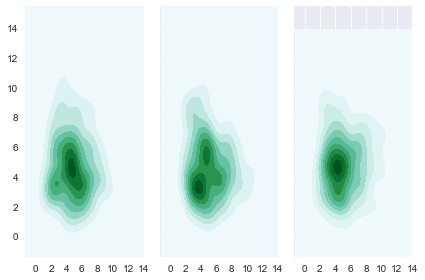

In [18]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(prior_length_scale), np.array(prior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_length_scale), shade=True, ax=axes[2])
fig.tight_layout()

### Hyperposterior

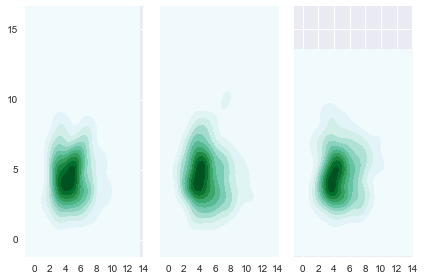

In [19]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(posterior_length_scale), np.array(posterior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_length_scale), shade=True, ax=axes[2])
fig.tight_layout()